In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.imagenet_utils import decode_predictions

In [3]:
# Preprocessing Tools
resNet_means =  np.array([103.939, 116.779, 123.68])

def preprocess(img):
    if len(img.shape) != 4:
        img = np.expand_dims(img, 0)
    return img - resNet_means
    
def deprocess(img):
    img = img + resNet_means
    print(img.min(), img.max())
    return np.clip(img, 0, 255).astype("uint8")

In [4]:
resNet = ResNet50(
                include_top=True,
                weights='imagenet',
                input_shape=(224, 224, 3)
)

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 2cb95161c43110f7111970584f804107 so we will re-download the data.
102973440/102967424 [==============================] - 70s 1us/step


We can load an image and predict its class.

In [5]:
pig_img = Image.open("./pig.jpg")

In [6]:
pig_224 = np.array(pig_img.resize((224, 224)))

In [7]:
pre_pig = preprocess(pig_224)

In [8]:
pre_pig.shape

(1, 224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


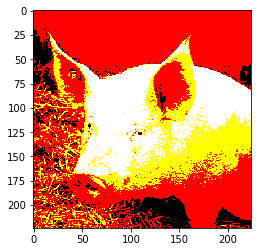

In [9]:
plt.imshow(pre_pig[0])
plt.show()

0.0 252.0


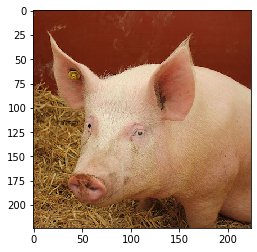

In [10]:
plt.imshow(deprocess(pre_pig)[0]);

In [11]:
pig_tensor = tf.convert_to_tensor(pre_pig)

In [12]:
preds = resNet(pig_tensor)

In [13]:
decode_predictions(preds.numpy())

[[('n02395406', 'hog', 0.9926414),
  ('n02396427', 'wild_boar', 0.007226759),
  ('n01704323', 'triceratops', 5.8049754e-05),
  ('n03935335', 'piggy_bank', 3.9354618e-05),
  ('n02397096', 'warthog', 7.1516733e-06)]]

We want to instead use the logits because they don't saturate.

In [14]:
resNet.get_layer("predictions").activation=None

In [15]:
preds = resNet(pig_tensor).numpy()

In [16]:
indx = np.argmax(preds, -1)[0]; indx

341

We can apply the softmax manually as:

$$
S(y_i) = \dfrac{e^{y_i}}{\sum_j e^{y_j}}
$$

In [17]:
np.exp(preds[0, indx]) / np.exp(preds).sum()

0.9926413

## Creating an Adversarial Example

In [18]:
resNet.trainable = False

We want to perturb the image $x$ by $\delta$. And so the prediction will be 

$$
h_{\theta}(x + \delta)
$$

We will constrain the changes so that :

$$
\Delta = \{ \delta : ||\delta||_\infty \le \epsilon \}
$$

and also that the image is within the range $\{0, 255\}$ so it remains a real image.

In [285]:
epsilon = 2

delta = tf.Variable(tf.zeros_like(pig_tensor),
                    name="delta", 
                    constraint=lambda x: tf.clip_by_value(x, -epsilon, epsilon)
                   )

opt = tf.keras.optimizers.Adam(learning_rate=0.2)

# Class to move away from
y = tf.one_hot([indx], 1000)

cross_entropy = tf.keras.losses.categorical_crossentropy

# target class
target = 1 # goldfish
y_t = tf.one_hot([target], 1000)

In [2]:
GREEK.avail()


           'alpha' : 'α',   'beta' : 'β',   'gamma' : 'γ', 'delta' : 'δ',
         'epsilon' : 'ε',   'zeta' : 'ζ',     'eta' : 'η', 'theta' : 'θ',
            'iota' : 'ι',  'kappa' : 'κ',   'lamda' : 'λ',    'mu' : 'μ',
              'nu' : 'ν',     'xi' : 'ξ', 'omicron' : 'ο',    'pi' : 'π',
             'rho' : 'ρ', 'fsigma' : 'ς',   'sigma' : 'σ',   'tau' : 'τ',
         'upsilon' : 'υ',    'phi' : 'φ',     'chi' : 'χ',   'psi' : 'ψ',
           'omega' : 'ω',
    
            # Upper
           "ALPHA" : "Α",   "BETA" : "Β",   "GAMMA" : "Γ",   "DELTA" : "Δ",
         "EPSILON" : "Ε",   "ZETA" : "Ζ",     "ETA" : "Η",   "THETA" : "Θ",
            "IOTA" : "Ι",  "KAPPA" : "Κ",   "LAMDA" : "Λ",      "MU" : "Μ",
              "NU" : "Ν",     "XI" : "Ξ", "OMICRON" : "Ο",      "PI" : "Π",
             "RHO" : "Ρ",  "SIGMA" : "Σ",     "TAU" : "Τ", "UPSILON" : "Υ", 
             "PHI" : "Φ",    "CHI" : "Χ",     "PSI" : "Ψ",   "OMEGA" : "Ω",
           "YMBOL" : "ϴ",
       
           # 

In [286]:
STEPS = 30
progress = tf.keras.utils.Progbar(STEPS)

for t in range(STEPS):    
    
    with tf.GradientTape() as tape:
        tape.watch(delta)
        
        x = pig_tensor + delta + epsilon
        #x = tf.clip_by_value(x, clip_value_min=pre_pig.min(), clip_value_max=pre_pig.max())
        pred = resNet(x)
        loss = (-cross_entropy(y, pred, from_logits=True) +
                cross_entropy(y_t, pred, from_logits=True))
        
    grads = tape.gradient(loss, [delta])

    opt.apply_gradients(zip(tf.math.sign(grads), [delta]))
    
    
    progress.update(t, values=[("loss", loss)])
    
    if (np.exp(pred)/np.exp(pred).sum())[0, target] > 0.9:
        print()
        print("Target > 90% confident")
        break
        

28/30 [===========================>..] - ETA: 0s - loss: -11.1188
Target > 90% confident


In [287]:
preds = resNet(pig_tensor+delta+epsilon).numpy()

In [288]:
np.argmax(preds)

1

In [289]:
target

1

In [290]:
pre_pig.min(), 

(-123.68,)

In [291]:
decode_predictions(np.exp(preds)/np.exp(preds).sum())

[[('n01443537', 'goldfish', 0.9322639),
  ('n02655020', 'puffer', 0.039104696),
  ('n01496331', 'electric_ray', 0.015493332),
  ('n09256479', 'coral_reef', 0.0072411923),
  ('n02606052', 'rock_beauty', 0.0018583447)]]

In [231]:
preds = resNet(preprocess(deprocess( (pre_pig+delta + epsilon).numpy() )))

0.0 253.9887367209729


In [232]:
decode_predictions(np.exp(preds)/np.exp(preds).sum())

[[('n02690373', 'airliner', 0.9999122),
  ('n04592741', 'wing', 5.0790066e-05),
  ('n03773504', 'missile', 1.0428309e-05),
  ('n04552348', 'warplane', 6.80339e-06),
  ('n04347754', 'submarine', 4.7370922e-06)]]

0.0 253.9887367209729


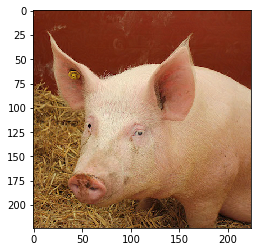

In [233]:
plt.imshow(deprocess((pre_pig+delta+epsilon).numpy())[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


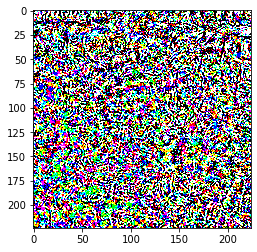

In [221]:
plt.imshow(50*delta.numpy()[0] + 0.5)
plt.show()

https://adversarial-ml-tutorial.org/introduction/

# Collection of Deltas

In [306]:
targets = [np.random.randint(100) for _ in range(5)]

deltas = []
for target in targets:

    epsilon = 3

    delta = tf.Variable(tf.zeros_like(pig_tensor),
                        name="delta", 
                        constraint=lambda x: tf.clip_by_value(x, -epsilon, epsilon)
                       )

    opt = tf.keras.optimizers.Adam(learning_rate=0.2)

    # Class to move away from
    y = tf.one_hot([indx], 1000)

    cross_entropy = tf.keras.losses.categorical_crossentropy

    # target class
    y_t = tf.one_hot([target], 1000)
    
    
    # OPTIMIZE
    
    STEPS = 50
    progress = tf.keras.utils.Progbar(STEPS)

    for t in range(STEPS):    

        with tf.GradientTape() as tape:
            tape.watch(delta)

            x = pig_tensor + delta #+ epsilon
            x = tf.clip_by_value(x, clip_value_min=pre_pig.min(), clip_value_max=pre_pig.max())
            pred = resNet(x)
            #loss = #(-cross_entropy(y, pred, from_logits=True) ) #+
            loss =    cross_entropy(y_t, pred, from_logits=True) 

        grads = tape.gradient(loss, [delta])

        opt.apply_gradients(zip(tf.math.sign(grads), [delta]))


        progress.update(t, values=[("loss", loss)])
        
        if (np.exp(pred)/np.exp(pred).sum())[0, target] > 0.95:
            print()
            print("Target > 95% confident")
            break
        
    deltas.append(delta)

18/50 [=========>....................] - ETA: 3s - loss: 4.1851
Target > 95% confident
18/50 [=========>....................] - ETA: 3s - loss: 5.1412
Target > 95% confident
22/50 [============>.................] - ETA: 2s - loss: 6.9024
Target > 95% confident
10/50 [=====>........................] - ETA: 4s - loss: 3.1759
Target > 95% confident
12/50 [======>.......................] - ETA: 3s - loss: 4.8895  ETA: 9s 
Target > 95% confident


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-3.0 252.0


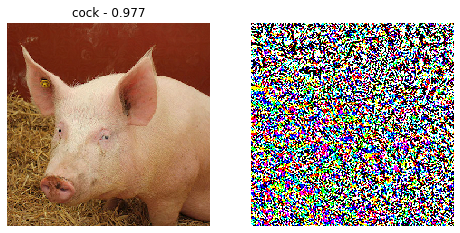

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-3.0 252.0


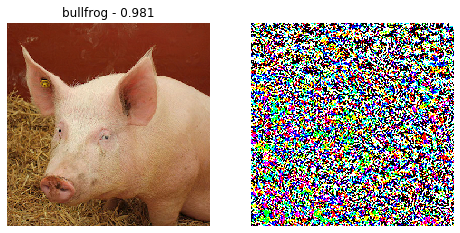

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-3.0 252.0


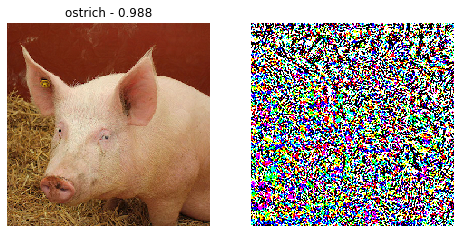

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-2.199996663279137 252.0


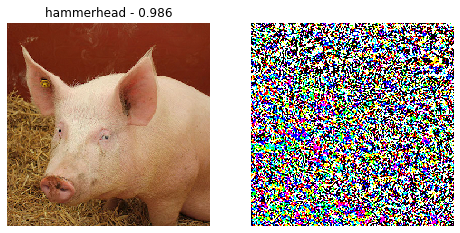

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-2.599996310222693 252.0


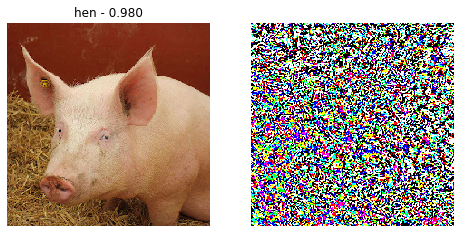

In [307]:
for delta in deltas:
    
    x = tf.clip_by_value(pig_tensor+delta,
                         clip_value_min=pre_pig.min(), clip_value_max=pre_pig.max())
    
    preds = resNet(x).numpy()
    
    cls = decode_predictions(np.exp(preds)/np.exp(preds).sum())[0][0]
    
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    
    ax[0].set_title(f"{cls[1]} - {cls[2]:.3f}")
    ax[0].imshow(deprocess((x).numpy())[0])
    ax[0].axis("off")
    ax[1].imshow(50*delta.numpy()[0] + 0.5)
    ax[1].axis("off")
    plt.show()
    

[24, 62, 47, 73, 14]

In [309]:
resNet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________